# Machine learning on a tabular dataset

Distinguishing Higgs boson (signal) events from events without Higgs.

You have learned to do it with cuts - "linearly".

Now let's try to distinguish the events with a machine learning classifier to increase the signal/background ratio and make the analysis more sensitive.

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

Follow the instructions here to install pytorch: https://pytorch.org/get-started/locally/

Pick your correct OS, I suggest to stick with the CPU version for now.

In [107]:
import pickle
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [108]:
data = pickle.load(open("htautau.pkl", "rb"))

In [109]:
data.keys()

dict_keys(['Run2012B_TauPlusX', 'DYJetsToLL', 'GluGluToHToTauTau', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'VBF_HToTauTau', 'Run2012C_TauPlusX', 'W3JetsToLNu'])

In [110]:
data["TTbar"].keys()

Index(['njets', 'npv', 'pt_1', 'eta_1', 'phi_1', 'm_1', 'iso_1', 'q_1', 'mt_1',
       'pt_2', 'eta_2', 'phi_2', 'm_2', 'iso_2', 'q_2', 'mt_2', 'dm_2',
       'jpt_1', 'jeta_1', 'jphi_1', 'jm_1', 'jbtag_1', 'jpt_2', 'jeta_2',
       'jphi_2', 'jm_2', 'jbtag_2', 'pt_met', 'phi_met', 'm_vis', 'pt_vis',
       'mjj', 'ptjj', 'jdeta', 'gen_match', 'run', 'weight'],
      dtype='object')

Let's take a look at one of the datasets - a ttbar simulation. This is a typical background process for many Higgs analyses, because the top quarks can decay into various channels which can fake a Higgs signal.

We have ~36k simulated events, and a number of features for each event.

In [111]:
data["TTbar"]

,njets,npv,pt_1,eta_1,phi_1,m_1,iso_1,q_1,mt_1,pt_2,...,pt_met,phi_met,m_vis,pt_vis,mjj,ptjj,jdeta,gen_match,run,weight
entry,,,,,,,,,,,,,,,,,,,,,
0,3,13,28.667351,1.562036,-0.842856,0.105658,0.000000,1,80.909939,36.405731,...,60.111469,2.751014,26.211727,60.862858,130.860291,38.344780,1.321880,False,1,0.402044
1,2,17,76.649849,-0.184059,1.773671,0.105658,0.009272,1,22.561057,28.185574,...,53.055363,1.418015,48.864986,102.870186,471.998077,151.001190,-2.423236,False,1,0.402044
2,5,20,40.108189,1.004245,2.685524,0.105658,0.031531,1,17.254477,20.238079,...,2.037169,-1.062208,60.555405,23.285250,207.719421,24.611734,0.925452,True,1,0.402044
3,2,18,17.215254,-1.608321,0.190183,0.105658,0.042270,-1,42.682263,26.714300,...,65.352066,-1.189085,45.746376,36.980255,139.373489,82.207253,-1.183147,False,1,0.402044
4,6,21,46.573315,-0.950096,2.138021,0.105658,0.057344,1,59.807889,47.802555,...,69.078201,1.027376,96.430687,94.001167,257.197113,101.881531,2.388012,False,1,0.402044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36861,6,22,23.628647,1.839439,1.272713,0.105658,0.132470,1,81.719287,20.719923,...,133.357239,2.903198,12.645602,43.711403,329.632202,46.506054,2.945638,False,1,0.402044
36862,1,13,18.357796,1.270961,2.813488,0.105658,0.027570,-1,64.936889,53.670872,...,96.485214,1.051181,90.164818,46.692497,-999.000000,-999.000000,-999.000000,False,1,0.402044
36863,2,17,52.057220,-0.379592,0.721136,0.105658,0.009719,1,39.442700,66.956032,...,65.936806,0.034499,116.174332,65.213791,88.366661,86.378456,0.057873,False,1,0.402044


Let's pick just two features - $M_{T,1}$ and $M_{T,2}$ at first.

In [112]:
keys = [
    "mt_1",
    "mt_2",
]

In [113]:
data["TTbar"][keys]

,mt_1,mt_2
entry,,
0,80.909939,92.667939
1,22.561057,3.189914
2,17.254477,1.133351
3,42.682263,79.947394
4,59.807889,69.045794
...,...,...
36861,81.719287,63.217953
36862,64.936889,134.028582
36863,39.442700,81.453346


In [114]:
X = torch.Tensor(data["TTbar"][keys].values) #feature matrix (Nevents, Nfeatures) = (~36k, 2)

y = torch.Tensor(np.zeros((len(X), 1), dtype=np.float32)) #target matrix/vector (Nevents, 1) = (~36k, 1)

ds_ttbar = TensorDataset(X, y)

X.shape, y.shape

(torch.Size([36866, 2]), torch.Size([36866, 1]))

In [115]:
X

tensor([[80.9099, 92.6679],
        [22.5611,  3.1899],
        [17.2545,  1.1334],
        ...,
        [39.4427, 81.4533],
        [12.3542, 23.5107],
        [48.8658, 89.9014]])

In [116]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [117]:
X = torch.Tensor(data["GluGluToHToTauTau"][keys].values)
y = torch.Tensor(np.ones((len(X), 1), dtype=np.float32))
ds_ggh = TensorDataset(X, y)
X.shape, y.shape

(torch.Size([8085, 2]), torch.Size([8085, 1]))

In [118]:
X

tensor([[ 12.2097, 103.8012],
        [ 30.5824,  60.9333],
        [ 52.0285,  27.2350],
        ...,
        [  3.6372, 115.7324],
        [  5.8181,  69.7466],
        [ 53.8415,   6.1458]])

In [119]:
y

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [120]:
len(ds_ttbar)

36866

In [121]:
len(ds_ggh)

8085

In [122]:
full_dataset = torch.utils.data.ConcatDataset([ds_ttbar, ds_ggh])
print("Full dataset", len(full_dataset))

Full dataset 44951


In [123]:
Nev = len(full_dataset)
Nev_half = int(Nev/2)

random_order = np.random.permutation(range(Nev))

In [124]:
random_order

array([35393, 17196, 17481, ..., 22755, 43595, 27075])

In [125]:
train_indices = random_order[:Nev_half]
test_indices = random_order[Nev_half:]

In [126]:
train_ds = torch.utils.data.dataset.Subset(full_dataset, train_indices)
test_ds = torch.utils.data.dataset.Subset(full_dataset, test_indices)
print(len(train_ds), len(test_ds))

22475 22476


In [127]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

Text(0, 0.5, 'mt_2')

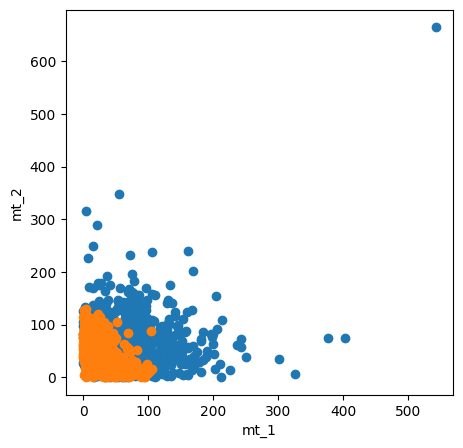

In [128]:
plt.figure(figsize=(5, 5))

idx_mt_1 = keys.index("mt_1")
idx_mt_2 = keys.index("mt_2")
plt.scatter(ds_ttbar.tensors[0][:1000, idx_mt_1], ds_ttbar.tensors[0][:1000, idx_mt_2])
plt.scatter(ds_ggh.tensors[0][:1000, idx_mt_1], ds_ggh.tensors[0][:1000, idx_mt_2])
plt.xlabel("mt_1")
plt.ylabel("mt_2")

Text(0, 0.5, 'mt_2')

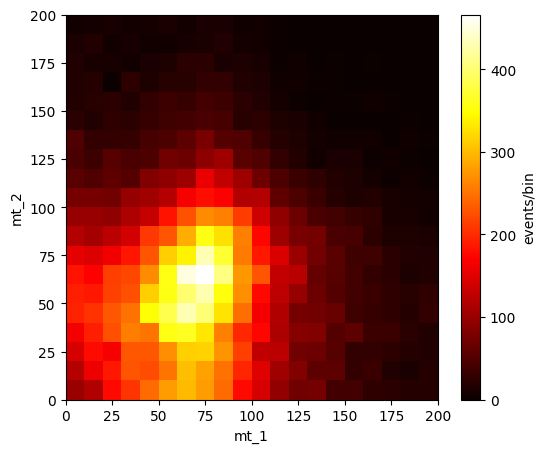

In [129]:
plt.figure(figsize=(6,5))

bins = np.linspace(0,200,21)
plt.hist2d(
    ds_ttbar.tensors[0][:, idx_mt_1].numpy(),
    ds_ttbar.tensors[0][:, idx_mt_2].numpy(), bins=(bins, bins), cmap="hot")
plt.colorbar(label="events/bin");
plt.xlabel("mt_1")
plt.ylabel("mt_2")

Text(0, 0.5, 'mt_2')

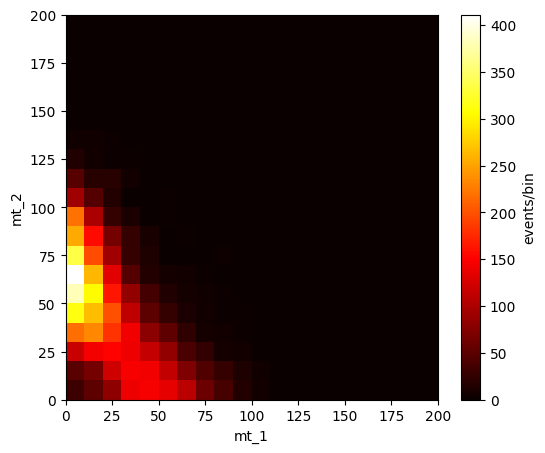

In [130]:
plt.figure(figsize=(6,5))

bins = np.linspace(0,200,21)
plt.hist2d(ds_ggh.tensors[0][:, idx_mt_1].numpy(), ds_ggh.tensors[0][:, idx_mt_2].numpy(), bins=(bins, bins), cmap="hot")
plt.colorbar(label="events/bin");
plt.xlabel("mt_1")
plt.ylabel("mt_2")

In [131]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        hidden_dim = 256
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
        
        self.act = torch.nn.ELU()
        
    def forward(self, x):
        
        #x: (32, 2) matrix
        
        x = self.act(self.lin1(x))
        
        #x: (32, 256) matrix
        
        x = self.act(self.lin2(x))
        #x: (32, 1) matrix

        x = torch.sigmoid(x)
        return x

net = Net(len(keys))

In [132]:
x = torch.Tensor([0.1, 100.0])
net(x)

tensor([1.], grad_fn=<SigmoidBackward0>)

In [133]:
net.lin1.bias.shape

torch.Size([256])

In [134]:
net.lin1.weight.shape

torch.Size([256, 2])

In [135]:
net.lin1.bias

Parameter containing:
tensor([ 0.1746, -0.3252,  0.1807, -0.4770,  0.6593,  0.3497,  0.3681, -0.6233,
         0.5416,  0.2062,  0.5732,  0.0249, -0.3487,  0.1611,  0.4772,  0.0160,
         0.1753,  0.3222, -0.1690,  0.4285,  0.3136,  0.5691, -0.2698, -0.1815,
        -0.6437, -0.4878, -0.3879, -0.5234, -0.1134,  0.5308,  0.2009,  0.0199,
         0.0073,  0.2299,  0.4835,  0.3341, -0.1526,  0.0729,  0.2800,  0.1663,
         0.5198, -0.1864, -0.0403, -0.3041, -0.4958, -0.3791,  0.5557, -0.5750,
         0.3286, -0.3906, -0.0598,  0.2972,  0.4845, -0.5811, -0.1363,  0.0814,
         0.6326, -0.0208, -0.4991, -0.4198, -0.5620,  0.1193,  0.2431,  0.1471,
        -0.5502,  0.5533,  0.4800,  0.5817, -0.1228,  0.6818, -0.3892, -0.0223,
         0.6358,  0.4901,  0.6100, -0.4522, -0.6628,  0.1279,  0.5275,  0.3000,
        -0.1068,  0.1217, -0.5852,  0.4339,  0.2915, -0.2119, -0.0654,  0.2950,
        -0.3630,  0.1135, -0.6574, -0.3305,  0.6503, -0.2334, -0.4725,  0.3251,
        -0.6422, -

In [136]:
net.lin1.weight

Parameter containing:
tensor([[-5.3068e-01, -8.3077e-02],
        [ 6.0581e-02, -1.3763e-01],
        [-5.9343e-01, -5.8650e-01],
        [ 2.3425e-01, -1.6017e-01],
        [ 4.7293e-01, -3.8766e-01],
        [-1.0623e-01,  1.5990e-01],
        [-4.4650e-01, -9.9626e-02],
        [-2.5439e-01,  4.1118e-01],
        [ 5.4810e-01, -1.9788e-01],
        [ 4.6720e-01,  4.1737e-02],
        [ 5.5120e-04,  1.1268e-01],
        [ 2.2957e-01, -6.8492e-01],
        [-9.5324e-02, -6.1831e-01],
        [-6.8522e-01,  2.5886e-01],
        [-4.6015e-01, -5.7005e-01],
        [ 4.1270e-01, -4.5451e-01],
        [ 4.6384e-01,  5.1181e-01],
        [-1.1180e-01, -4.3496e-01],
        [ 3.8035e-01,  1.7974e-01],
        [ 6.2453e-01,  3.8410e-01],
        [ 5.7132e-01, -1.2280e-01],
        [ 6.0577e-02, -2.6462e-01],
        [ 2.0572e-01,  2.1867e-01],
        [ 4.0446e-01,  4.1705e-01],
        [ 1.7080e-01, -1.4214e-01],
        [-1.8233e-01, -1.0522e-01],
        [-1.6378e-01, -6.9777e-01],
      

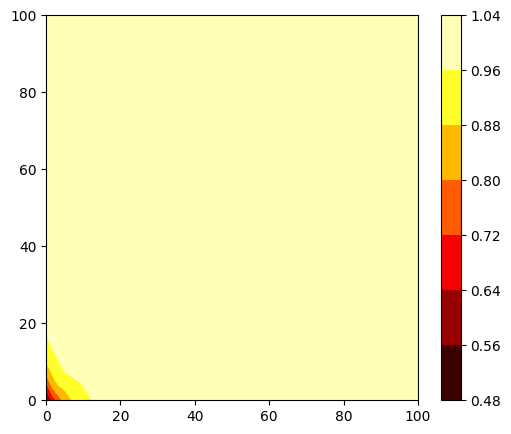

In [137]:
vals_mt = torch.Tensor(np.linspace(0,100,100))

grid_x, grid_y = torch.meshgrid(vals_mt, vals_mt, indexing='ij')
preds = net(torch.stack([grid_x, grid_y], axis=-1)).detach()[:, :, 0]

fig = plt.figure(figsize=(6,5))
ax1 = plt.contourf(grid_x.numpy(), grid_y.numpy(), preds.numpy(), cmap="hot")
plt.colorbar()

In [138]:
import torch.optim as optim

criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=0.0001)

We want to minimize the loss function across predictions $p\in[0,1]$ and labels $y\in\{0, 1\}$ by tuning the model parameters:

$$
L(p,y)
$$

For classification, binary cross-entropy loss:
$$
    L(p,y) = - \left[ y \cdot \log p + (1 - y) \cdot \log (1 - p) \right],
$$

In [139]:
criterion(torch.Tensor([0.99]), torch.Tensor([1.0]))

tensor([0.0101])

In [140]:
criterion(torch.Tensor([0.99]), torch.Tensor([0.0]))

tensor([4.6052])

In [141]:
#evaluate across multiple values at the same time
criterion(torch.Tensor([0.99, 0.3]), torch.Tensor([0.0, 1.0]))

tensor([4.6052, 1.2040])

In [142]:
for x in train_loader:
    print(x[0].shape, x[1].shape)
    print(x[0])
    print(x[1])
    break

torch.Size([32, 2]) torch.Size([32, 1])
tensor([[ 86.0033,  44.0319],
        [ 12.6808,  56.5509],
        [102.2431,  69.1306],
        [ 65.9179,  43.3295],
        [101.5018,   0.8894],
        [148.8618,  50.4729],
        [107.0682,  62.7439],
        [155.2467,  26.3365],
        [ 75.7391,   1.9624],
        [258.6005,  55.7348],
        [ 99.1425,  17.5306],
        [102.5519,  24.6248],
        [112.0116, 119.5830],
        [  8.4127, 170.5930],
        [ 96.0914,  61.5821],
        [ 36.9563,  35.0728],
        [ 12.4579,  63.6121],
        [165.5271,  97.4166],
        [ 81.6820, 118.6354],
        [ 81.8228,  78.4586],
        [ 45.1240,  51.9320],
        [ 39.4958,  49.6899],
        [ 56.6706,  14.1194],
        [ 23.8420,  70.6413],
        [ 16.2113,  25.0730],
        [ 90.4267,  62.6577],
        [ 75.4022, 131.3593],
        [  7.6113, 143.9193],
        [ 69.0113, 110.0914],
        [ 19.6033,  49.4883],
        [121.5386,  70.8860],
        [ 51.7851,  27.3247]])

In [143]:
loss_train_vals = []
loss_test_vals = []


lin1_weight_std = []
lin1_weight_mean = []
for epoch in range(50):  # loop over the dataset multiple times

    loss_train = 0.0
    for i, batch_data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch_data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss = torch.sum(loss)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_train += loss.item()
        
        lin1_weight_std.append(net.lin1.weight.std().detach().numpy())
        lin1_weight_mean.append(net.lin1.weight.mean().detach().numpy())
    
    loss_train_vals.append(loss_train)
    
    loss_test = 0.0
    with torch.no_grad():
        for i, batch_data in enumerate(test_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch_data

            # forward
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss = torch.sum(loss)

            # print statistics
            loss_test += loss.item()
    loss_test_vals.append(loss_test)

    print("Epoch {}: {:.2f}/{:.2f}".format(epoch, loss_train, loss_test))

Epoch 0: 65577.79/11090.71
Epoch 1: 11018.49/11075.34
Epoch 2: 10861.36/10866.53
Epoch 3: 10400.21/10398.83
Epoch 4: 10359.05/10439.60
Epoch 5: 10345.36/10451.38
Epoch 6: 10372.61/10385.92
Epoch 7: 10360.77/10441.40
Epoch 8: 10371.54/10451.12
Epoch 9: 10357.78/10472.52
Epoch 10: 10372.26/10473.61
Epoch 11: 10360.43/10363.82
Epoch 12: 10367.08/10405.81
Epoch 13: 10362.19/10358.70
Epoch 14: 10345.05/10358.64
Epoch 15: 10356.15/10360.54
Epoch 16: 10337.75/10410.30
Epoch 17: 10354.17/10448.29
Epoch 18: 10302.88/10336.58
Epoch 19: 10311.38/10361.04
Epoch 20: 10308.72/10398.52
Epoch 21: 10311.33/10334.43
Epoch 22: 10307.98/10444.61
Epoch 23: 10306.41/10342.70
Epoch 24: 10290.19/10307.24
Epoch 25: 10309.69/10380.02
Epoch 26: 10274.87/10296.94
Epoch 27: 10260.66/10420.47
Epoch 28: 10269.58/10567.85
Epoch 29: 10272.05/10384.65
Epoch 30: 10256.95/10670.47
Epoch 31: 10268.91/10269.36
Epoch 32: 10243.92/10265.69
Epoch 33: 10232.85/10299.51
Epoch 34: 10234.93/10261.83
Epoch 35: 10251.31/10266.14
Ep

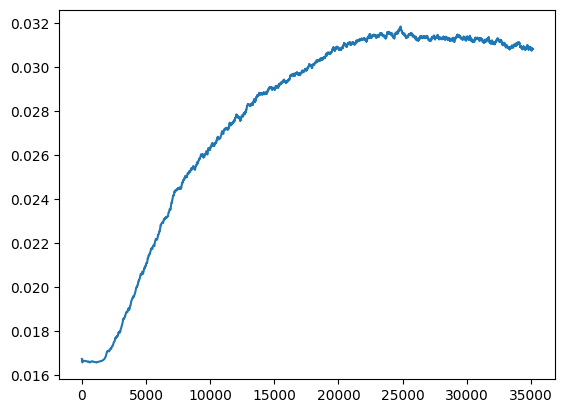

In [144]:
plt.plot(np.stack(lin1_weight_mean))

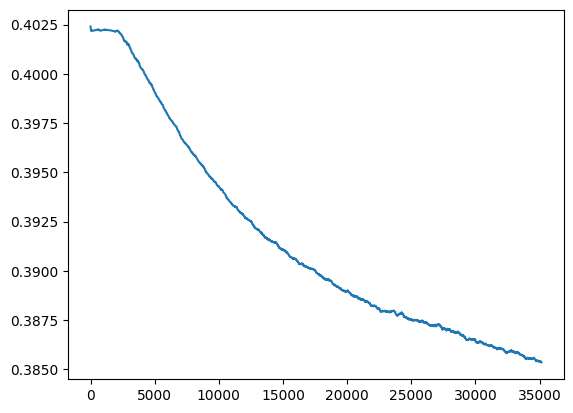

In [145]:
plt.plot(np.stack(lin1_weight_std))

Text(0, 0.5, 'Total loss')

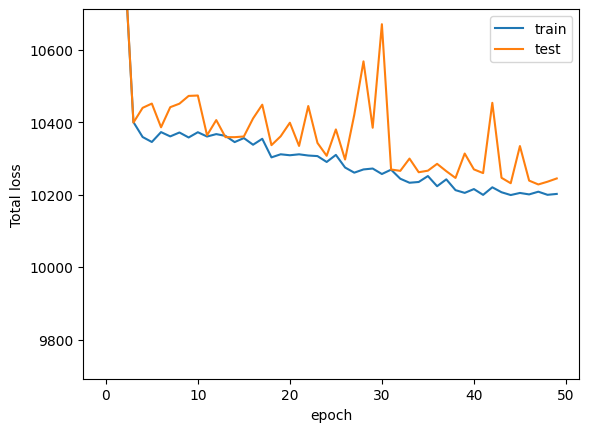

In [146]:
plt.plot(loss_train_vals, label="train")
plt.plot(loss_test_vals, label="test")
plt.ylim(loss_train_vals[-1]*0.95, loss_train_vals[-1]*1.05)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Total loss")

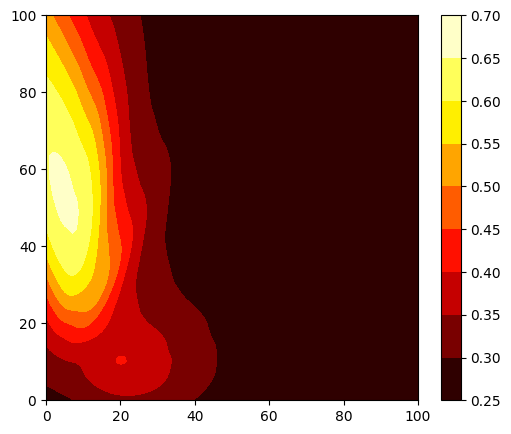

In [147]:
vals_mt = torch.Tensor(np.linspace(0,100,100))

grid_x, grid_y = torch.meshgrid(vals_mt, vals_mt, indexing='ij')
preds = net(torch.stack([grid_x, grid_y], axis=-1)).detach()[:, :, 0]

fig = plt.figure(figsize=(6,5))
ax1 = plt.contourf(grid_x.numpy(), grid_y.numpy(), preds.numpy(), cmap="hot")
plt.colorbar()

In [148]:
from sklearn.metrics import roc_curve

In [149]:
train_ds

In [150]:
X_train = np.stack([x[0] for x in train_ds], axis=0)
X_train.shape

(22475, 2)

In [151]:
X_train

array([[91.642265, 64.62616 ],
       [81.70796 , 80.372375],
       [38.91207 , 43.59554 ],
       ...,
       [90.239204, 28.869856],
       [23.780619, 97.84121 ],
       [76.92588 , 95.32581 ]], dtype=float32)

In [152]:
y_train = np.stack([x[1] for x in train_ds], axis=0)
y_train.shape

(22475, 1)

In [153]:
X_test = np.stack([x[0] for x in test_ds], axis=0)
y_test = np.stack([x[1] for x in test_ds], axis=0)

In [154]:
X_test

array([[ 19.54841  ,  74.15976  ],
       [  1.9096597, 137.80946  ],
       [ 57.577435 ,  45.767902 ],
       ...,
       [ 70.43052  , 122.72194  ],
       [ 32.996605 ,  22.440521 ],
       [ 85.13477  ,  63.870556 ]], dtype=float32)

In [155]:
y_test

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [156]:
ypred_train = net(torch.Tensor(X_train)).detach().numpy()
ypred_test = net(torch.Tensor(X_test)).detach().numpy()

In [157]:
ypred_train[:100]

array([[0.26896203],
       [0.26896432],
       [0.28214705],
       [0.27221557],
       [0.26895192],
       [0.2816134 ],
       [0.26894343],
       [0.26913968],
       [0.5413212 ],
       [0.2689573 ],
       [0.26894143],
       [0.26952407],
       [0.2703123 ],
       [0.27074432],
       [0.31352758],
       [0.2691882 ],
       [0.30010605],
       [0.28082526],
       [0.2691305 ],
       [0.27960315],
       [0.2913189 ],
       [0.6485454 ],
       [0.27472827],
       [0.268965  ],
       [0.26910862],
       [0.28064886],
       [0.3739074 ],
       [0.31462565],
       [0.6402383 ],
       [0.48000073],
       [0.26897824],
       [0.26896906],
       [0.29082432],
       [0.26894143],
       [0.26894778],
       [0.2689415 ],
       [0.2689562 ],
       [0.27002683],
       [0.3527248 ],
       [0.2696444 ],
       [0.26895007],
       [0.3074479 ],
       [0.27479017],
       [0.29868466],
       [0.26896474],
       [0.37625   ],
       [0.2689736 ],
       [0.268

In [158]:
ypred_test[:100]

array([[0.39072785],
       [0.3315546 ],
       [0.2706312 ],
       [0.2702635 ],
       [0.2689418 ],
       [0.2689415 ],
       [0.2689415 ],
       [0.26894164],
       [0.55533886],
       [0.6465529 ],
       [0.26972106],
       [0.27077177],
       [0.2689515 ],
       [0.26894146],
       [0.26895964],
       [0.5558228 ],
       [0.31153056],
       [0.27566195],
       [0.26903632],
       [0.6284841 ],
       [0.26894578],
       [0.26897496],
       [0.3293054 ],
       [0.26903445],
       [0.26936457],
       [0.26900965],
       [0.26895693],
       [0.26895362],
       [0.27360573],
       [0.57180774],
       [0.47298768],
       [0.26896363],
       [0.2700463 ],
       [0.2697995 ],
       [0.268977  ],
       [0.27024385],
       [0.32317618],
       [0.27458385],
       [0.26894885],
       [0.26896167],
       [0.26926506],
       [0.26896554],
       [0.26895383],
       [0.35246277],
       [0.30229172],
       [0.6508546 ],
       [0.3713972 ],
       [0.269

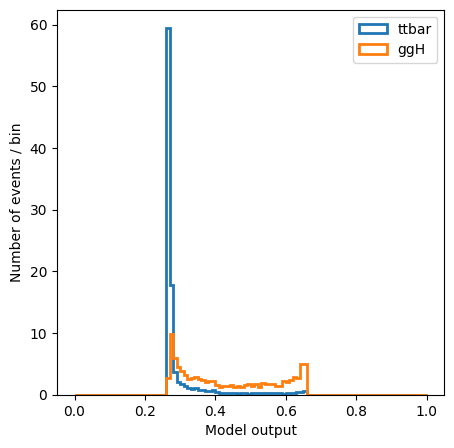

In [159]:
plt.figure(figsize=(5,5))
b = np.linspace(0, 1, 101)
plt.hist(ypred_train[y_train[:, 0]==0], bins=b, histtype="step", lw=2, label="ttbar", density=True);
plt.hist(ypred_train[y_train[:, 0]==1], bins=b, histtype="step", lw=2, label="ggH", density=True);
#plt.yscale("log")
plt.xlabel("Model output")
plt.ylabel("Number of events / bin")
plt.legend()

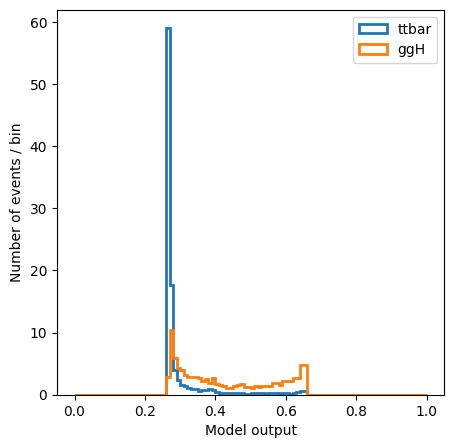

In [160]:
plt.figure(figsize=(5,5))
b = np.linspace(0, 1, 101)
plt.hist(ypred_test[y_test[:, 0]==0], bins=b, histtype="step", lw=2, label="ttbar", density=True);
plt.hist(ypred_test[y_test[:, 0]==1], bins=b, histtype="step", lw=2, label="ggH", density=True);
#plt.yscale("log")
plt.xlabel("Model output")
plt.ylabel("Number of events / bin")
plt.legend()

In [161]:
fpr_train, tpr_train, _ = roc_curve(y_train, ypred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, ypred_test)

Text(0, 0.5, 'TPR')

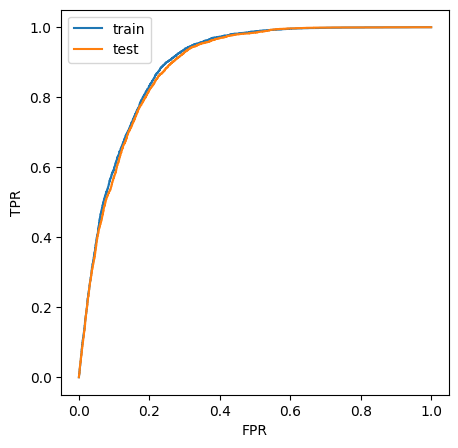

In [162]:
plt.figure(figsize=(5,5))
plt.plot(fpr_train, tpr_train, label="train")
plt.plot(fpr_test, tpr_test, label="test")
plt.legend(loc="best")
plt.xlabel("FPR")
plt.ylabel("TPR")

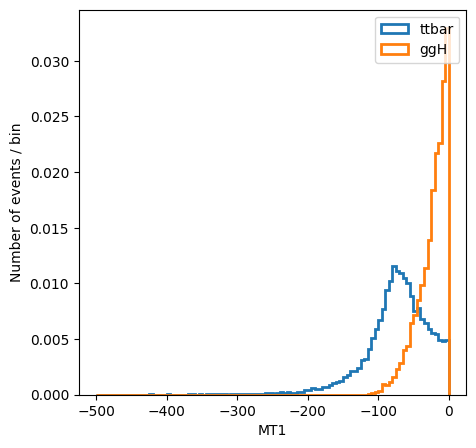

In [163]:
plt.figure(figsize=(5,5))
b = np.linspace(-500, 0, 101)
plt.hist(-X_test[y_test[:, 0]==0, 0], bins=b, histtype="step", lw=2, label="ttbar", density=1);
plt.hist(-X_test[y_test[:, 0]==1, 0], bins=b, histtype="step", lw=2, label="ggH", density=1);
#plt.yscale("log")
plt.xlabel("MT1")
plt.ylabel("Number of events / bin")
plt.legend()

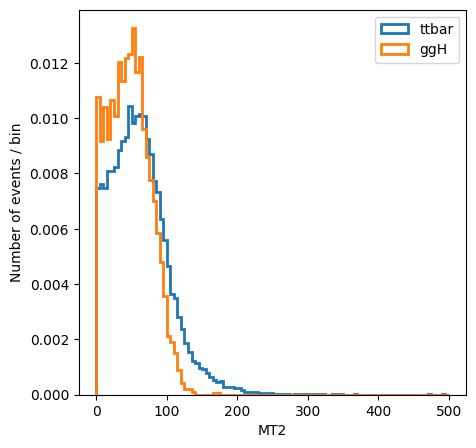

In [164]:
plt.figure(figsize=(5,5))
b = np.linspace(0, 500, 101)
plt.hist(X_test[y_test[:, 0]==0, 1], bins=b, histtype="step", lw=2, label="ttbar", density=1);
plt.hist(X_test[y_test[:, 0]==1, 1], bins=b, histtype="step", lw=2, label="ggH", density=1);
#plt.yscale("log")
plt.xlabel("MT2")
plt.ylabel("Number of events / bin")
plt.legend()

In [165]:
fpr_test_mt1, tpr_test_mt1, _ = roc_curve(y_test, -X_test[:, 0])
fpr_test_mt2, tpr_test_mt2, _ = roc_curve(y_test, -X_test[:, 1])

Text(0, 0.5, 'True Positive Rate')

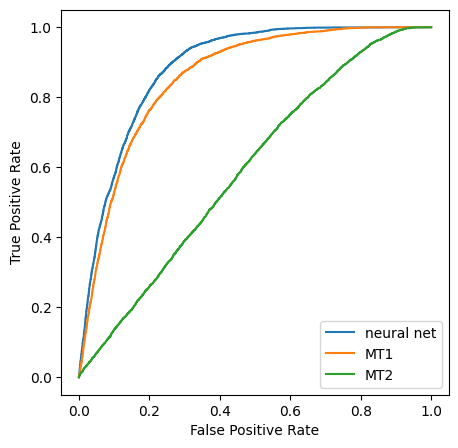

In [166]:
plt.figure(figsize=(5,5))
plt.plot(fpr_test, tpr_test, label="neural net")
plt.plot(fpr_test_mt1, tpr_test_mt1, label="MT1")
plt.plot(fpr_test_mt2, tpr_test_mt2, label="MT2")
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Exercise 1: evaluate the classifier on other datasets

Compute the pretrained classifier output distribution on dataset that were not used in training, e.g. the DYJetsToLL, W1JetsToLNu, W2JetsToLNu backgrounds.
Do the model outputs resemble signal or background?

In [167]:

def evaluate_classifier_on_dataset(dataframe, feature_keys):
    X = torch.Tensor(dataframe[feature_keys].values)
    preds = net(X).detach().numpy()
    return preds


def plot_model_on_dataset(samples, bin_range):
    plt.figure(figsize=(10,5))
    for dataset_name in samples:
        preds = evaluate_classifier_on_dataset(data[dataset_name], keys)
        plt.hist(preds, bins=bin_range, density=1, label=dataset_name, histtype="step", lw=2)
    plt.legend(ncol=3)
    #plt.yscale("log")
    plt.xlabel("Model output")
    plt.ylabel("Normalized number of events / bin")

## Exercise 2: add additional simulated datasets for training

To improve the generalization performance of the model, add the other datasets (both signal and background) with the appropriate weights.

In [168]:
data.keys()

dict_keys(['Run2012B_TauPlusX', 'DYJetsToLL', 'GluGluToHToTauTau', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'VBF_HToTauTau', 'Run2012C_TauPlusX', 'W3JetsToLNu'])

In [169]:
keys

['mt_1', 'mt_2']

In [170]:
def prepare_feature_matrix(dataframe, feature_keys):
    X = torch.Tensor(dataframe[feature_keys].values)
    return X

def prepare_target_matrix(num_events, is_signal=True):
    if is_signal:
        y = np.ones((num_events, 1), dtype=np.float32)
    else:
        y = np.zeros((num_events, 1), dtype=np.float32)
    return torch.Tensor(y)

background_datasets = []
for dataset_name in ['DYJetsToLL', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu']:
    df = data[dataset_name]
    X = prepare_feature_matrix(df, keys)
    y = prepare_target_matrix(X.shape[0], is_signal=False)
    print(dataset_name, X.shape, y.shape)
    dataset = TensorDataset(X, y)
    background_datasets.append(dataset)
    
signal_datasets = []
for dataset_name in ['GluGluToHToTauTau', 'VBF_HToTauTau']:
    df = data[dataset_name]
    X = prepare_feature_matrix(df, keys)
    y = prepare_target_matrix(X.shape[0], is_signal=True)
    print(dataset_name, X.shape, y.shape)
    dataset = TensorDataset(X, y)
    signal_datasets.append(dataset)
#...

all_datasets = torch.utils.data.ConcatDataset(background_datasets+signal_datasets)

DYJetsToLL torch.Size([70123, 2]) torch.Size([70123, 1])
TTbar torch.Size([36866, 2]) torch.Size([36866, 1])
W1JetsToLNu torch.Size([23970, 2]) torch.Size([23970, 1])
W2JetsToLNu torch.Size([42396, 2]) torch.Size([42396, 1])
W3JetsToLNu torch.Size([23954, 2]) torch.Size([23954, 1])
GluGluToHToTauTau torch.Size([8085, 2]) torch.Size([8085, 1])
VBF_HToTauTau torch.Size([10492, 2]) torch.Size([10492, 1])


In [171]:
len(all_datasets)

215886

In [172]:
def split_dataset(dataset):
    random_order = np.random.permutation(len(dataset))
    Nev_train = int(len(dataset)/2)
    train_indices = random_order[:Nev_train]
    test_indices = random_order[Nev_train:]
    train_ds = torch.utils.data.dataset.Subset(dataset, train_indices)
    test_ds = torch.utils.data.dataset.Subset(dataset, test_indices)
    
    return train_ds, test_ds

In [173]:
train_ds, test_ds = split_dataset(all_datasets)

In [174]:
len(train_ds), len(test_ds)

(107943, 107943)

In [175]:
i = 0
for elem in train_ds:
    print(elem)
    i+=1
    if i>10:
        break

(tensor([124.0564,  40.2254]), tensor([0.]))
(tensor([  6.2306, 129.8212]), tensor([0.]))
(tensor([ 34.0478, 193.6785]), tensor([0.]))
(tensor([140.1823,   6.3820]), tensor([0.]))
(tensor([ 7.4256, 58.9863]), tensor([1.]))
(tensor([106.2646,  52.3565]), tensor([0.]))
(tensor([29.4279, 67.5485]), tensor([0.]))
(tensor([210.3799,  40.3088]), tensor([0.]))
(tensor([ 5.8771, 83.9419]), tensor([0.]))
(tensor([119.4589, 109.6552]), tensor([0.]))
(tensor([4.5492, 8.1523]), tensor([1.]))


In [176]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [177]:
i = 0
for elem in train_loader:
    print(elem)
    i+=1
    if i>10:
        break

[tensor([[182.8006,  33.7388],
        [ 51.8506,  98.1552],
        [ 30.9752,   1.0818],
        [ 23.4981,  42.6767],
        [ 17.0186,  47.8742],
        [ 87.1229,  46.2768],
        [ 84.3619,  55.1478],
        [ 43.6999,  11.5801],
        [  2.7042,  76.4771],
        [ 33.7422,   3.7886],
        [ 33.3572,  58.7880],
        [ 81.6541,  37.3861],
        [ 89.9236,  38.1474],
        [ 83.2301,  30.9494],
        [ 71.7006,  20.8960],
        [ 72.0444,  99.9043],
        [ 43.3236,  41.2990],
        [  6.7151,  71.7336],
        [100.0179,  33.5379],
        [ 18.6511,  71.2936],
        [  9.0641,  27.1921],
        [ 72.7610,  60.4399],
        [ 37.2006,  38.6244],
        [ 49.2073,   2.2164],
        [ 59.8518,  46.7504],
        [101.6262,  40.0355],
        [ 19.1672, 166.4805],
        [ 68.1003,   6.9571],
        [ 98.1716,  57.4338],
        [ 13.7074,  70.5014],
        [ 16.5773,  62.6963],
        [ 32.4978,  71.9671]]), tensor([[0.],
        [0.],
        [

In [178]:
def train_model(net, train_loader, test_loader, num_epochs):
    loss_train_vals = []
    loss_test_vals = []
    
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        loss_train = 0.0
        for i, batch_data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch_data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss = torch.sum(loss)

            loss.backward()
            optimizer.step()

            # print statistics
            loss_train += loss.item()

            lin1_weight_std.append(net.lin1.weight.std().detach().numpy())
            lin1_weight_mean.append(net.lin1.weight.mean().detach().numpy())

        loss_train_vals.append(loss_train)

        loss_test = 0.0
        with torch.no_grad():
            for i, batch_data in enumerate(test_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = batch_data

                # forward
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                loss = torch.sum(loss)

                # print statistics
                loss_test += loss.item()
        loss_test_vals.append(loss_test)

        print("Epoch {}: {:.2f}/{:.2f}".format(epoch, loss_train, loss_test))
    return loss_train_vals, loss_test_vals

In [179]:
net = Net(len(keys))
loss_train_vals, loss_test_vals = train_model(net, train_loader, test_loader, 5)

Epoch 0: 51029.33/43139.67
Epoch 1: 43103.14/43120.97
Epoch 2: 43092.91/43117.32
Epoch 3: 43090.37/43116.54
Epoch 4: 43089.74/43116.41


(43085.42865112116, 43094.04659864614)

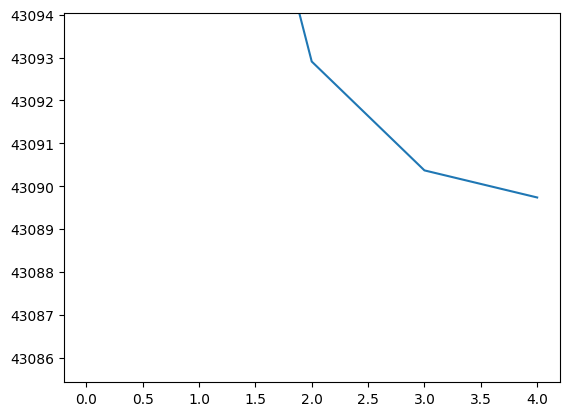

In [180]:
plt.plot(loss_train_vals)
plt.ylim(loss_train_vals[-1]*0.9999, loss_train_vals[-1]*1.0001)

(43112.102235622646, 43120.725518398045)

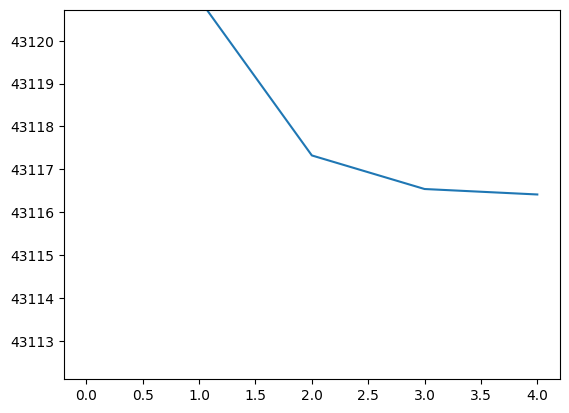

In [181]:
plt.plot(loss_test_vals)
plt.ylim(loss_test_vals[-1]*0.9999, loss_test_vals[-1]*1.0001)

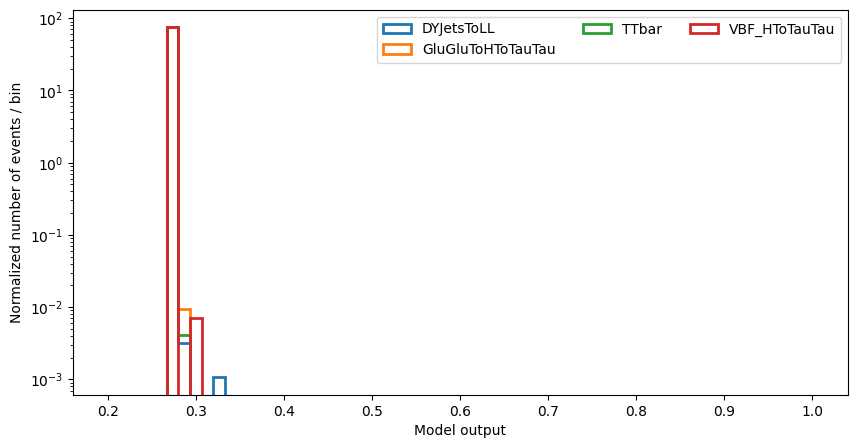

In [182]:
plot_model_on_dataset(
    ['DYJetsToLL', 'GluGluToHToTauTau', 'TTbar', 'VBF_HToTauTau'], np.linspace(0.2, 1.0, 61))
plt.yscale("log")

In [183]:
X_test = np.stack([x[0] for x in test_ds], axis=0)
y_test = np.stack([x[1] for x in test_ds], axis=0)

In [184]:
y_pred_test = net(torch.Tensor(X_test)).detach().numpy()
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

Text(0, 0.5, 'TPR')

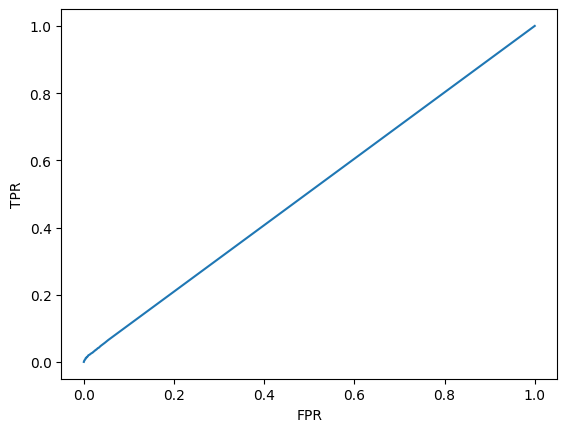

In [185]:
plt.plot(fpr_test, tpr_test)
plt.xlabel("FPR")
plt.ylabel("TPR")

## Exercise 3: add additional variables to the classifier



Add additional input variables / observed features to the classifier. Compare the performance to the two-variable (mt1, mt2) classifier.

In [186]:
keys_new = [
    "njets", "npv",
    "pt_1", "eta_1", "phi_1", "m_1", "iso_1", "q_1",
    "mt_1",
    "pt_2", "eta_2", "phi_2", "m_2", "iso_2", "q_2",
    "mt_2",
    "dm_2",
    "jpt_1", "jeta_1", "jphi_1", "jm_1", "jbtag_1",
    "jpt_2", "jeta_2", "jphi_2", "jm_2", "jbtag_2",
    "pt_met", "phi_met", "m_vis", "pt_vis",
]

## Exercise 4: Evaluate on data, compare data/MC

Evalute the model predictions on data, prepare a data/MC comparison plot of the model outputs.

In [193]:
background_datasets_new = []
for dataset_name in ['DYJetsToLL', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu']:
    df = data[dataset_name]
    X = prepare_feature_matrix(df, keys_new)
    y = prepare_target_matrix(X.shape[0], is_signal=False)
    print(dataset_name, X.shape, y.shape)
    dataset = TensorDataset(X, y)
    background_datasets_new.append(dataset)
    
signal_datasets_new = []
for dataset_name in ['GluGluToHToTauTau', 'VBF_HToTauTau']:
    df = data[dataset_name]
    X = prepare_feature_matrix(df, keys_new)
    y = prepare_target_matrix(X.shape[0], is_signal=True)
    print(dataset_name, X.shape, y.shape)
    dataset = TensorDataset(X, y)
    signal_datasets_new.append(dataset)
#...

all_datasets_new = torch.utils.data.ConcatDataset(
        background_datasets_new+signal_datasets_new)

DYJetsToLL torch.Size([70123, 31]) torch.Size([70123, 1])
TTbar torch.Size([36866, 31]) torch.Size([36866, 1])
W1JetsToLNu torch.Size([23970, 31]) torch.Size([23970, 1])
W2JetsToLNu torch.Size([42396, 31]) torch.Size([42396, 1])
W3JetsToLNu torch.Size([23954, 31]) torch.Size([23954, 1])
GluGluToHToTauTau torch.Size([8085, 31]) torch.Size([8085, 1])
VBF_HToTauTau torch.Size([10492, 31]) torch.Size([10492, 1])


In [194]:
train_ds, test_ds = split_dataset(all_datasets_new)
len(train_ds), len(test_ds)

(107943, 107943)

In [189]:
"""i = 0
for elem in train_ds:
    print(elem)
    i+=1
    if i>10:
        break"""

'i = 0\nfor elem in train_ds:\n    print(elem)\n    i+=1\n    if i>10:\n        break'

In [195]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [196]:
i = 0
for elem in train_loader:
    print(elem)
    i+=1
    if i>5:
        break

[tensor([[ 0.0000e+00,  2.3000e+01,  4.7824e+01,  1.1443e+00, -1.4700e+00,
          1.0566e-01,  1.2435e-02, -1.0000e+00,  7.9673e+01,  2.1321e+01,
         -2.2818e-01, -6.9189e-01,  7.9505e-01,  1.5204e-01,  1.0000e+00,
          5.0943e+01,  1.0000e+00, -9.9900e+02, -9.9900e+02, -9.9900e+02,
         -9.9900e+02, -9.9900e+02, -9.9900e+02, -9.9900e+02, -9.9900e+02,
         -9.9900e+02, -9.9900e+02,  3.3425e+01,  1.8418e+00,  5.3213e+01,
          6.4763e+01],
        [ 1.0000e+00,  1.0000e+01,  2.4391e+01, -5.3237e-01,  3.0155e+00,
          1.0566e-01,  5.7177e-02,  1.0000e+00,  6.6753e+01,  2.3236e+01,
          3.7195e-01,  1.5453e+00,  9.6572e-01,  1.0362e-01, -1.0000e+00,
          5.5713e+01,  1.0000e+01,  3.4822e+01, -8.0799e-01, -1.9466e+00,
          8.3290e+00,  1.7554e-01, -9.9900e+02, -9.9900e+02, -9.9900e+02,
         -9.9900e+02, -9.9900e+02,  4.6976e+01, -4.6090e-01,  3.8957e+01,
          3.5336e+01],
        [ 1.0000e+00,  1.7000e+01,  2.1920e+01, -6.9938e-01,  2.8

In [198]:
net_new = Net(len(keys_new))
loss_train_vals, loss_test_vals = train_model(
                        net_new, train_loader, test_loader, 10)

Epoch 0: 6520110.90/6518160.11
Epoch 1: 6518959.38/6517361.64
Epoch 2: 6518569.53/6517311.03
Epoch 3: 6518401.10/6517226.61
Epoch 4: 6518316.53/6517051.11
Epoch 5: 6518234.38/6517089.37
Epoch 6: 6518236.23/6517052.74
Epoch 7: 6518109.68/6517333.89
Epoch 8: 6518098.76/6516944.95
Epoch 9: 6518049.76/6516707.55


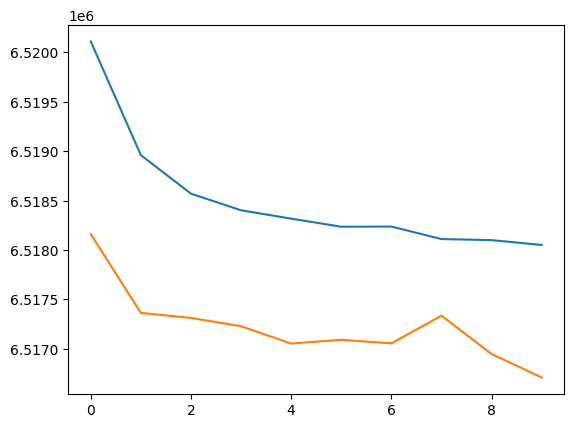

In [199]:
plt.plot(loss_train_vals)
plt.plot(loss_test_vals)
#plt.ylim(loss_test_vals[-1]*0.9999, loss_test_vals[-1]*1.0001)

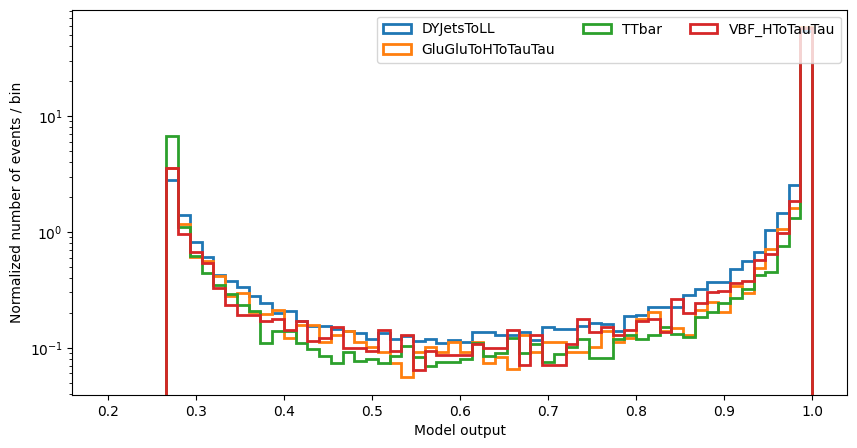

In [200]:
plot_model_on_dataset(
    ['DYJetsToLL', 'GluGluToHToTauTau', 'TTbar', 'VBF_HToTauTau'], np.linspace(0.2, 1.0, 61))
plt.yscale("log")